# **Designing an RL Example for Optimal Order Execution**

### 1. Introduction

The following code implements a "toy" RL example for optimal order execution. Due to the nature of data used (less granular L2 / MBP as opposed to full granular L3 / MBO), the RL environment relies on a set of assumptions that are a departure from a fully realistic simulated market. Despite the simplified model, the general approach and employed concepts are transferrable to a more complete RL application, which I shortly discuss in more detail at the end of the notebook.

The dataset used in this example is way too small to realistically train an RL agent that is able to generalize over multiple conditions. Instead, we knowingly overfit the RL framework on the given small dataset, avoiding the train / test / validate split otherwise used in a proper setting. While the result is not usable in practice, it is sufficient to prove that the framework has an ability to learn on a provided dataset.

On a further note - The proposed setup also puts a bit more focus on the environment design than on the actual RL learning methodology. This is deliberate - we'd rather have a properly designed RL environment and iterate on the RL learning method rather than have the newest RL learning method but a crappy environment to operate in (garbage in, garbage out...). Plus, there's a lot of available RL libraries to play around with, but the simulation environment for financial markets is a much more closed space, especially if we want full simulation granularity.

We will initially discuss the environment design. Towards the end of the notebook, the environement designed and discussed is employed in an example triaining loop. This particular implementation uses a actor-critic approach, cumulative multistep rewards, achieved via benchmarking against a vanilla TWAP order execution strategy with an LSTM and some tricks for smartly parsing the LOB data in the policy network. 

### 2. Setup

Get the imports required to execute the notebook. In order to avoid clogging the notebook with code the particular implementations have been placed in outside  in *.py files, they are however commented too in order to illustrate the approach. This implementation also tries to keep dependencies minimal, since it is mainly didactic. As available data and environment complexity scales, it will be advantageous to use existing RL toolkits and training  environements such as Gym, Ray, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataProvision import DataFeed
import RLAnalytics
import ScheduleExecutor
import pandas as pd
from OrderExecutor import OrderExecutor
from BacktesterL2 import Backtester
from RLEnvironment import RLEnvironment
import torch
from typing import Tuple, List, Optional
from torch.distributions import Categorical, Beta
from torch.nn import init
from RLNetwork import RLAgent, TSM_LSTM
import random
np.random.seed(123)
torch.manual_seed(123)

### 3. Data

The data used for this notebook was scraped from Bitstamp, and consists of roughly 300 seconds of an ETH/USD market. While Bitstamp provides variable depth orderbook snapshots, we will trim the orderbook down to the top 10 levels on both Bid and Ask sides. Note we are using the DataFeed class as well as methods defined in RLAnalytics.py for plotting. DataFeed is a simple parser for the Bitstamp L2 data and provides utilities to spawn Generators for the datafeed when we use it in training. The provded LOBRecorder.py can be used to scrape new data from Bitstamp.

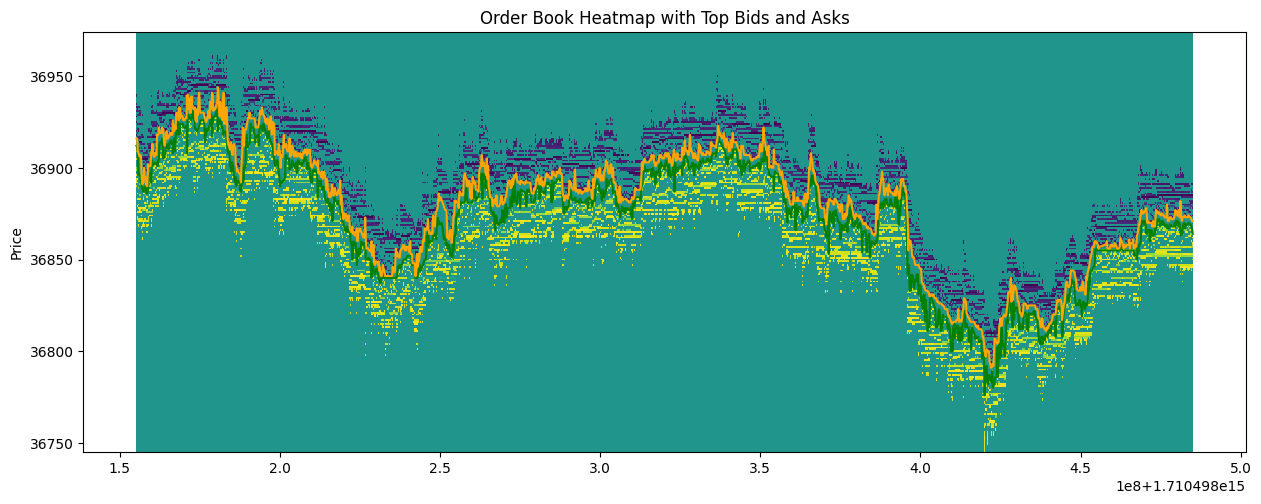

In [2]:
# get the data
data = pd.read_csv("LOBL2.csv")
data = data.set_index(data.iloc[:, 0]).iloc[:, 1::]
data_feed = DataFeed(data, levels=10)
RLAnalytics.plot_dataset(data_feed)

### 4. Environment: Backtester

The design of the environment is mainly guided by the granularity of the available data. An ideal setup would have a full agent-based market simulation, with latency simulation, individual decision modelling to take into account market participant feedback as well as full visibility into the order queues at individual price levels. That's obviously non-trivial, so to keep things simple we'll go for L2 data scraped from an existing market (in this case bitstamp), no simulated agents or anything fancy, just LOB MPB snapshots. I'm happy to also showcase a fully real-time agent-based simulated environment (I have this in much more performant C++, but the code is personal IP from my own stack which I'd rather not share in a non-commercial setting since a lot of work went into that)

The first challenge is to now build a simulation environment where the agent can (back-)test its actions. The fact that we don't have full visibility of queues at individual price levels forces us to make a lot of rather strong assumptions.

- Limit orders are matched if the opposite top of book crosses the posted limit order price. The amount of volume on the price levels that cross the placed order price determines the maximum amount available for fill.
- If a placed limit order is only partially filled, it rests on the book for subsequent ticks. As long as price levels on the opposite side continue to cross the posted order price, fills will happen with the available volume.
- Note that above mechanism is anything but conservative - probability of fill is actually overestimated since any placed order does not persistently mutate the state of the LOB, and the implicit assumption is that a placed order is always front of queue. We will fix these overly favorable conditions in the execution module later on; by forcing limit orders to adapt their price to a more conservative level as the LOB evolves, even when they are resting. This is completely unrealistic and would cause both high transaction costs and queue penalties in real life, but still more conservative than the other approach. This also highlights the trade-offs we have to enter by relying on L2 data only for market simulation.
- The LOB is updated by simply feeding in the next L2 LOB snapshot data, which also triggers matching according to aforementioned rules.

Here is a quick example of just using the backtester:

In [3]:
data = pd.read_csv("LOBL2.csv")
data = data.set_index(data.iloc[:, 0]).iloc[:, 1::]
levels = 10
init_time = 0
# ini the backtester
backtester = Backtester()
data_feed = DataFeed(data, levels)
gen = data_feed.raw_data_yield_fun(init_time)
# get first data point
index, new_bids, new_asks = next(gen)
# init book
_, _, _ = backtester.step(new_bids, new_asks, index)
# get a price near the top
price = backtester.lob.get_best_bid() - backtester.tick_size
# place at that price
order_id = backtester.place_virtual_limit_order(price, 100000000, "bid")
print("Placed limit order")
all_executed_trades = []
for  index, new_bids, new_asks in gen:
    executed_trades, to_remove_limit_orders, to_remove_market_orders = backtester.step(new_bids, new_asks, index)
    all_executed_trades += executed_trades
    print("Backtester updated with new data, index: "+str(index)+", num trades: "+str(len(executed_trades)))
    if len(backtester.virtual_limit_orders) == 0:
        break
print("Trades executed {price: volume}: " + str([trade.price_levels for trade in all_executed_trades]))

Placed limit order
Backtester updated with new data, index: 1710498155420787, num trades: 0
Backtester updated with new data, index: 1710498155609596, num trades: 1
Backtester updated with new data, index: 1710498155812349, num trades: 1
Backtester updated with new data, index: 1710498155999485, num trades: 1
Trades executed {price: volume}: [{36909: 54187325}, {36908: 2709439}, {36907: 43103236}]


### 4. Environment: OrderExecutor

This is essentially a wrapper around the L2 backtester, and implements backtesting logic specific to a single order, w.r.t. the optimal trade execution problem we want to solve. A given limit or market order placement can be simulated / backtested here, since this class executes multiple timesteps until a given order is exshausted.
- The class executes a single placement of a given limit or market order. 
- Limit order prices are set automatically, relative to the top of the book, as a function of the spread. A positive multiplier means aggressive pricing, sets the price into the spread. A negative multiplier is conservartive and set the price at a depth below the top. A negative multiplier can also be seen as a simulation of latency and / or slippage.
- limit orders are executed accross multiple ticks if the order is not immmediately filled, until the full volume is exhausted. The "resubmit_each_tick" flag has the class re-submit a resting limit order each tick at a new price (using the previous spread-based pricing logic). This imposes a conservative assumption on fill probabiltity, as it requires the opposite price to again cross the spread of the previous tick in order to cause a fill. We set this flag to true unless there's a reason not to be conservative.
- the class also provides a similiar logic for market orders - they are re-submitted each tick if not fully filled until volume is exhausted.

Below code shows the operation of the OrderExecutor. Simulating i.e. a limit order outputs various analytics, including a pandas frame indexed by time with "Trade" objects, the same as illustrated previously.

In [4]:
data = pd.read_csv("LOBL2.csv")
data = data.set_index(data.iloc[:, 0]).iloc[:, 1::]
max_time = (data.index[-1] - data.index[0]) / 3 * 2
env = OrderExecutor(10)
backtester = Backtester()
data_feed = DataFeed(data, levels=10)
data_gen = data_feed.raw_data_yield_fun(0)
order_volume = 61000000
side = "bid"
trade_data, remaining_volume, tick_data_bids, tick_data_asks, placed_orders = env.simulate_limit_order(data_gen, order_volume, side, max_time)
print(trade_data)

{1710498155420787: [<BacktesterL2.Trade object at 0x15339d450>], 1710498155609596: [<BacktesterL2.Trade object at 0x15339c090>], 1710498155812349: [<BacktesterL2.Trade object at 0x1534d6890>], 1710498155999485: [<BacktesterL2.Trade object at 0x15341cf10>]}


### 5. Environment: ScheduleExecutor

Here we move from simulating a single order to simulating the execution of a given schedule which consists of multiple orders. The class also provides methods to estimate the reward of executing a given order placement schedule.
- As mentioned previously, our environment has to deal with delayed rewards, as is the nature of placing limit orders. While there are techniques to estimate immediate rewards, we'll keep it simple and train our policy on the cumulative reward of a full order placement schedule.
- Reward is calculated at the end of the schedule, as the difference between the RL agents cumulative VWAP of the executed schedule, vs a cumulative VWAP of the TWAP benchmark.
- More advanced implementations could attempt to work with immediate rewards. In that case, not a schedule but a single resting limit order already spawns a reward, priced i.e. by hypothetical market walk. These approaches have to be designed carefully due to the delayed reward nature of placing a limit order. Another more granular option would be that every tick returns a reward, which still has the same challenges. Again as previosuly noted, L3 data would remove a lot of the heuristics we'd have to employ.

The ScheduleExecutor expects a schedule which it will execute. Here is an example of such a schedule:


In [5]:
# Schedule parameters (note the conversion from seconds to microseconds necessary)
max_time = int(3 * 1e6)
max_volume = int(3 * 1e6)
side = "bid"
num_schedule_elements = 3
# create the schedule
schedule = {}
for i in range(num_schedule_elements):
    schedule.update({i: ScheduleExecutor.LimitEvent(side, max_time, max_volume)})
# add a market event at the end which offloads any remaining volume
schedule.update({len(schedule): ScheduleExecutor.MarketEvent(side, max_time)})
print(schedule)

{0: <ScheduleExecutor.LimitEvent object at 0x1531cc8d0>, 1: <ScheduleExecutor.LimitEvent object at 0x152a8a810>, 2: <ScheduleExecutor.LimitEvent object at 0x1533329d0>, 3: <ScheduleExecutor.MarketEvent object at 0x15339cbd0>}


As mentioned previously, 300 seconds of LOB data won't really get us far if we want to train a proper RL Agent for optimzing order execution. But its good enough to illustrate what we're trying to achieve. In the RL context, a single episode that yields a reward will be the full execution of a given order schedule. Below we construct an equally spaced, constant-volume order execution schedule (this would be the output of a regular TWAP schedule):

In [6]:
# Schedule parameters (note the conversion from seconds to microseconds necessary)
max_time = int(3 * 1e6)
max_volume = int(3 * 1e6)
side = "bid"
num_schedule_elements = 3
# create the schedule
schedule = {}
for i in range(num_schedule_elements):
    schedule.update({i: ScheduleExecutor.LimitEvent(side, max_time, max_volume)})
# add a market event at the end which offloads any remaining volume
schedule.update({len(schedule): ScheduleExecutor.MarketEvent(side, max_time)})

We can run this simple schedule on the dataset using utilities from RLAnalytics.py. Here we execute the schedule with a rather aggressive pricing strategy, placing bid orders pretty deep into the spread (price is set 0.7 * spread above top bid).

<Axes: ylabel='Price'>

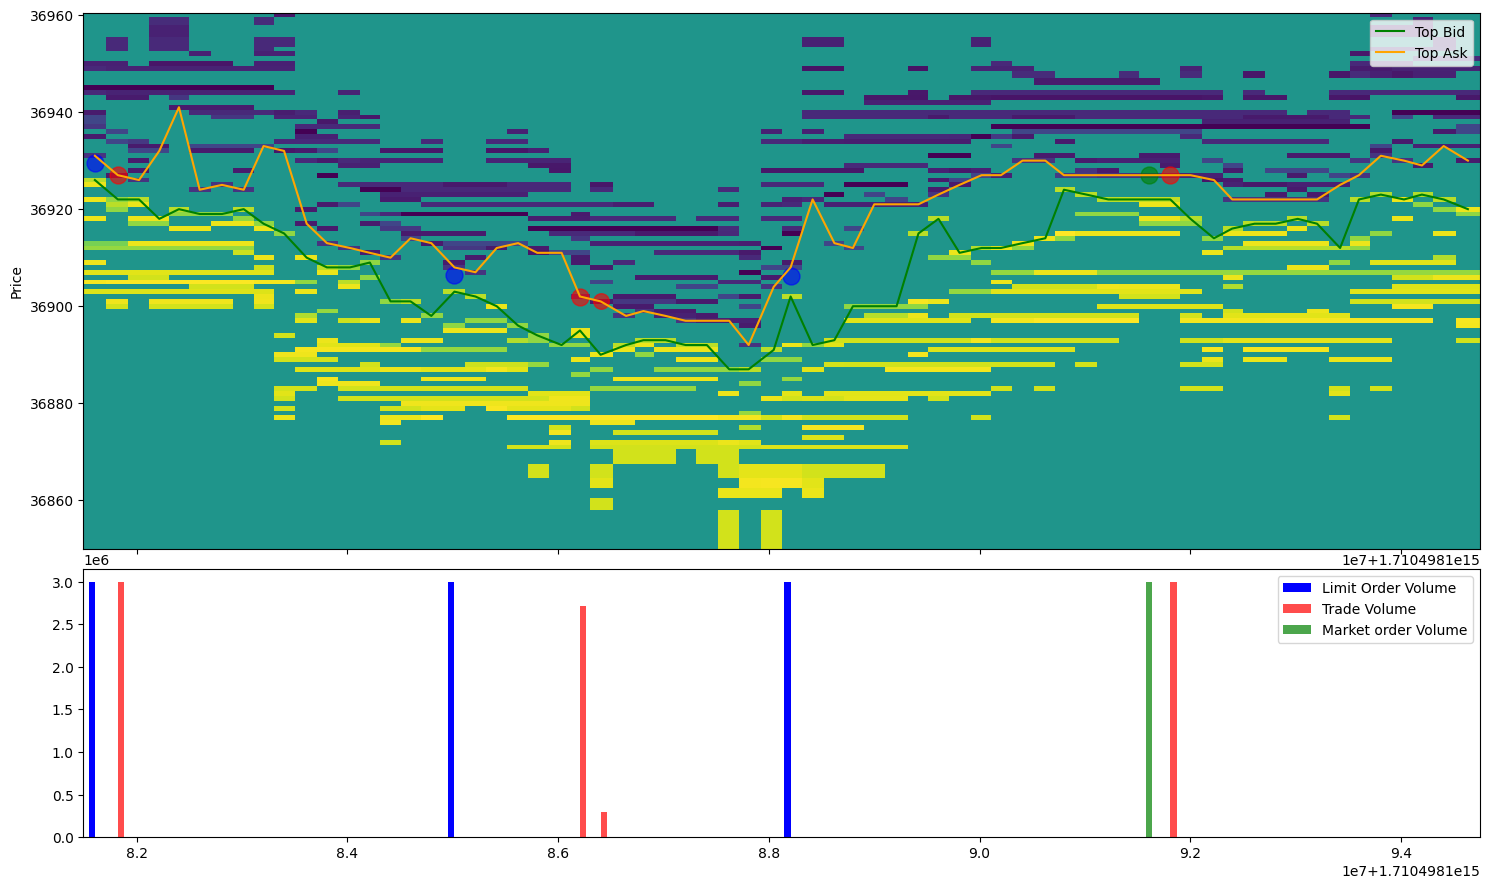

In [7]:
# get data
data_gen = DataFeed(data, levels=10).raw_data_yield_fun(1710498181404675)
# run schedule
RLAnalytics.plot_lob_data_with_volume(schedule, data_gen, resubmit_each_tick=False, price_level_offset=0.7)

- Blue dot: Limit order
- Green dot: Market order
- Red dot: trade

Note also the "resubmit_each_tick" flag. If activated, it re-submits the order with a new adapted price each tick, which lowers the probabiltity of fill for resting orders - we require the ask side to cross into bid not only once for a fill, but at every tick, leading to potentially delayed fills:

<Axes: ylabel='Price'>

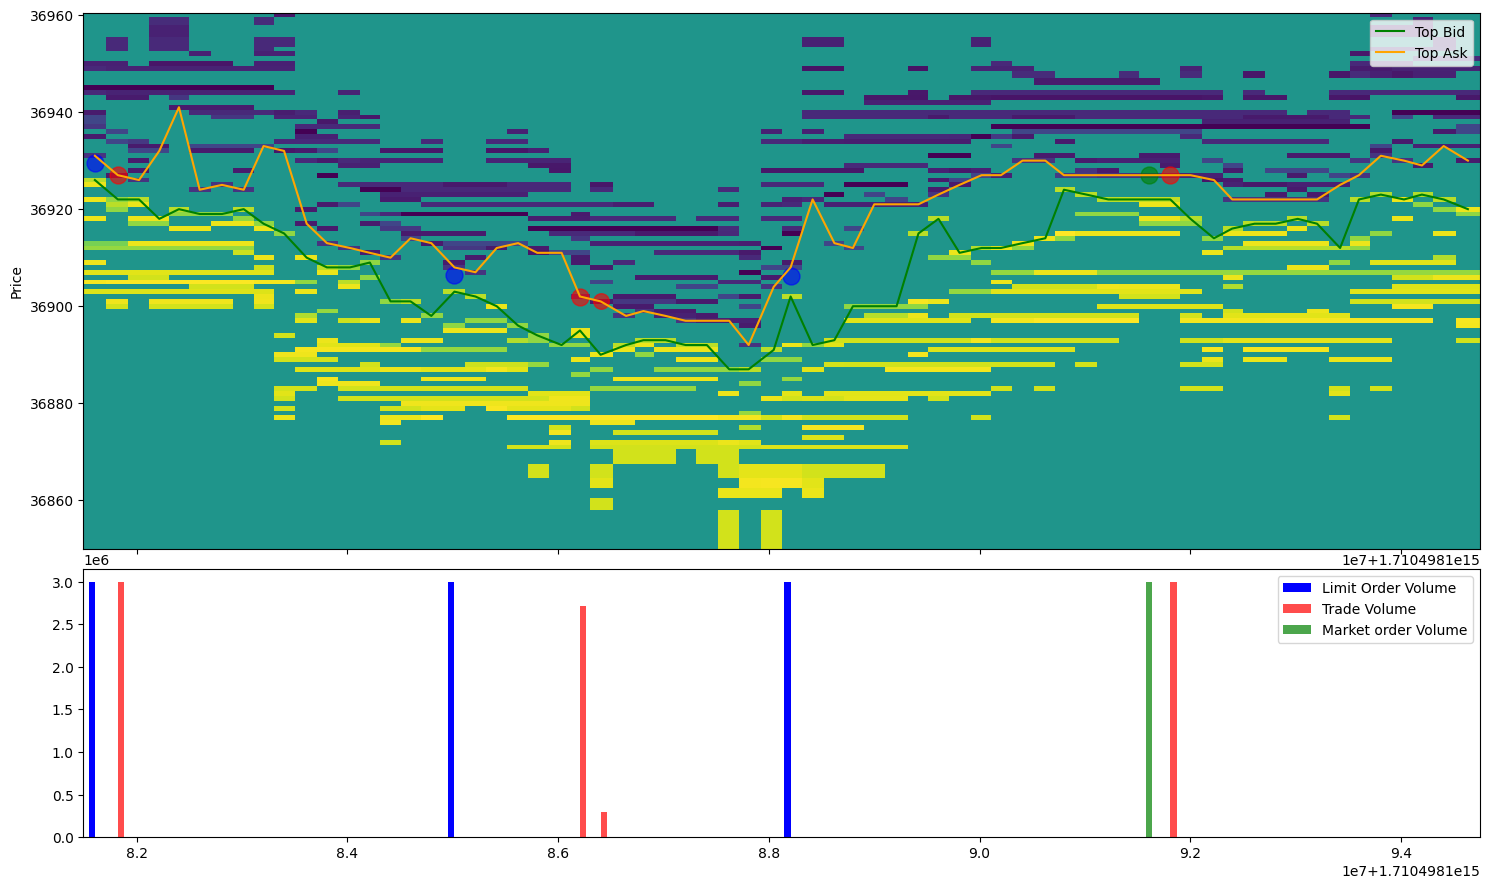

In [17]:
data_gen = DataFeed(data, levels=10).raw_data_yield_fun(1710498181404675)
RLAnalytics.plot_lob_data_with_volume(schedule, data_gen, resubmit_each_tick=False, price_level_offset=0.7)

The choice of activating this flag or not is dependent on the requirements for the resulting agent. This is an example of the complicating circumstances we have due to the nature of only working with L2 as opposed to fully granular L3. The parameter should be chosen according to the market we are operating on.

### 6. The RL Learning setup

Having established the data, we will now implement an example RL learning setup, using the environment tools described in the Environemnt notebook. This part is experimental and usually pretty iterative - getting a stable RL learning setup can be challenging, especially in dynamic environments such as markets and orderbooks. We can consider some of the environment parameters to be roughly established:

- Rewards are delayed. While an agent has access to an updated environment state at each tick and can take action based on that, the agent will not be able to observe the reward for the taken action until some steps into the future. Only when the placed orders are eventually filled, a "cumulative" reward can be inferred. This is commonly known as the "Credit Assignment problem" 
- The action space is limited by the environment to a scalar multiplier on the order volume already proided by the TWAP benchmark. We have the constraint that we ultimately want to net to 0 on the final remaining volume. There is already an implicit penalization for this if thew constraint is not met, since the environment forces the RL agent to perform a market order on all the remaining volume at the end which usually comes at a cost. There is no control over order price, it is a function of the current LOB state. Timing is also outside the scope of this example environment.
- Given that we are dealing with financial markets, it would make sense to assume that a well-founded action is not only conditioned on the current state, but also on historical states.


Because of the delayed reward structure, a common approach is to use a  actor-critic-advantage method. On a high level, this method provides estimates of the expected return of a action given the state using a critic network - this value can be used as a heuristic to quantify the value of intermediate rewards which otherwise wouldn't be available. The general setup can be described as follows:


**Actor-Critic Framework**

- The Actor-Critic methods consist of two models: An Actor suggesting actions, and a Critic evaluating them.
- $s_t$ is the state at time $t$.
- Actor outputs a policy $\pi(a_t | s_t)$, which is a probability distribution over actions given the current state.
- The Critic estimates the value function $V^\pi(s_t)$, the expected return from state $s_t$ following policy $\pi$.

**The Actor-Critic Network**

- The Actor-Critic Network combined network outputs both action probabilities and state values
- The actor part is responsible for outputting the action probabilities given the current environemnt and agent state $s$. It learns to select actions that maximize the expected cumulative reward. The output are action probabilities $\pi(a|s)$
- The critic part estimates the value function. It provides feedback to the Actor by evaluating the quality of the chosen actions. It outputs the scalar $V(s)$ which represents the expected return from state $s$ under policy $\pi$.
- actor and critic network could also be 2 compeltely separate networks, this is a design choice.

**Advantage Function**

- The advantage function becomes relevant when learning the gradient
- Advantage $A(a, s)$ measures the relative quality of an action at a given state.
- $A(a, s) = Q(s, a) - V(s)$, where $Q(s, a)$ is the action-value function.
- Often estimated as $R + \gamma V(s_{t+1}) - V(s_t)$, with $R$ as the reward and $\gamma$ as the discount factor.

**Exploration Strategy**

- An agent needs to be encouraged to explore the action space, in order to also make mistakes so it can learn from them. This usually means that some stochastic component is included.
- If we are working with a continuous action space, we could model the networks action output directly as the parameters for a distribution. This will naturally provide exploration if a low-probability action is sampled
- If we are working ina  discerete action space, we can employ epsilon-greedy. With probability $\epsilon$, the agent chooses a random action, with probability $1 - \epsilon$, agent chooses the best action as per the policy. We can have $\epsilon$ decay over time.

**Loss Functions and Updates**

- Losses for actor and critic networks guide model updates.
- Actor Loss: $-\log(\pi(a_t|s_t)) \cdot A(a_t, s_t)$.
- Critic Loss: Mean Squared Error (MSE) between estimated value and return $(V(s_t) - R_t)^2$.

**Training Loop**

- 2 basic approaches are available: per step gradient updates, or episodal cumulative gradient updates. 
- Both of them involve the basic sequence: action, reward, and state transition.
- Iterate through episodes.
- Update the network based on calculated losses, using the advantage function

### 7. Environment: Reinforcement Learner
Based on this setup, lets build a simplified setup using a continuous action space. Recall that the action is a multiplier on a given TWAP volume. It makes sense to restrict possible values for this action in the continuous space $[0, 1]$. In order to generate an action in this space, we employ a actor-critic network that outputs the parameters of Beta Distribution. 

The probability density function (PDF) of the Beta distribution is given by:

$f(x; \alpha, \beta) = \frac{x^{\alpha-1}(1 - x)^{\beta-1}}{B(\alpha, \beta)}$

where $(x)$ is the random variable, $(\alpha > 0)$ and $(\beta > 0)$ are shape parameters, $(B(\alpha, \beta))$ is the beta function, defined as $(B(\alpha, \beta) = \int_{0}^{1} t^{\alpha-1}(1 - t)^{\beta-1} dt)$. PyTorch provides an easy access to do this via the distributions module.

The Beta distribution has a range of $[0, 1]$, we simply scale the output by $* 2$ to achieve the desired action space. Because we are outputting a distribution, the agent will sample from this output during learning. The distribution provides a way to also retrieve the log-probability of a given sample, which we use during the policy update to assign a "quality" of an action while calculating the total advantage.

The following class inherits from a base class RLEnvironment that takes care of setting up the environements, backtesters, trianing loops etc. Note also that this implementation updates the policy gradient episodically using accumulated losses (hence "multistep"). This is an implementation detail, this actor-critic setup would also allow us to update gradients on a per-step basis (after the completion of an episode). Per-step gradient updates maybe a bit noisier, but provided enough data the network may learn to better attribute values to per step actions too.

In [9]:
class RLEnvironment_continuous_beta(RLEnvironment):
    def __init__(self, policy_network, buffer_size, resubmit_each_tick, price_depth_penalty):
        super(RLEnvironment_continuous_beta, self).__init__(policy_network, buffer_size, resubmit_each_tick, price_depth_penalty)
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.gamma = 0.99

    def _select_agent_action(self, state: torch.Tensor) -> Tuple[float, Optional[torch.Tensor], Optional[torch.Tensor]]:
        # Normalize the input state
        state_norm = (state - state.mean()) / (state.std() + 1e-5)

        # Pass state through the network to get action logits and state value
        distribution, state_value = self.policy_network(state_norm)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)
        action_out = action.item() * 2

        # Return the selected action, its log probability, and the state value
        return action_out, log_prob, state_value

    def _select_agent_action_inference(self, state: torch.Tensor) -> Tuple[float, Optional[torch.Tensor], Optional[torch.Tensor]]:
        # Normalize the input state
        state_norm = (state - state.mean()) / (state.std() + 1e-5)

        # Pass state through the network to get action logits and state value
        distribution, state_value = self.policy_network(state_norm)
        action = distribution.mean

        log_prob = distribution.log_prob(action)
        action_out = action.item() * 2

        # Return the selected action, its log probability, and the state value
        return action_out, log_prob, state_value

    def _update_policy_multistep(self, all_values_per_step: List[torch.Tensor], all_states_per_step: List[torch.Tensor], all_action_per_step: List[float], all_log_prob_per_step: List[Optional[torch.Tensor]], all_rewards_per_step: List[float], cumulative_reward: float, done: bool) -> torch.Tensor:
        returns = []
        R = cumulative_reward  # Starting with the final reward

        # Backpropagate the discounted cumulative reward to each step
        for step in reversed(range(len(all_states_per_step))):
            returns.insert(0, R)
            R = R * self.gamma  # Discount the reward for the next earlier step

        # Convert returns to a PyTorch tensor
        returns = torch.tensor(returns, dtype=torch.float32)

        actor_losses = []
        critic_losses = []
        for log_prob, value, R in zip(all_log_prob_per_step, all_values_per_step, returns):
            advantage = R - value.squeeze()

            # Actor loss: -log_prob * advantage
            actor_loss = -log_prob * advantage
            actor_losses.append(actor_loss)

            # Critic loss: F.mse_loss or another suitable loss function
            critic_loss = torch.nn.functional.mse_loss(value.squeeze(0), torch.tensor([R]))
            critic_losses.append(critic_loss)

        # Take the mean of the accumulated losses
        actor_loss = torch.stack(actor_losses).mean()
        critic_loss = torch.stack(critic_losses).mean()

        # Update both actor and critic
        self.optimizer.zero_grad()
        total_loss = actor_loss + critic_loss
        total_loss.backward()
        self.optimizer.step()
        return total_loss

### 8. Agent: Actor Critic Network

Lets define the actual actor-critic network. As previosuly noted, it makes sense to have a network that models time to some degree, using historical buffered states. We'll use an LSTM for this. Furthermore, this network architecture has some specialized layers that treat environemnt LOB states differently to agent states at the input, basically providing the network with some feature engineering on network level:

In [10]:
class ActorCriticNetwork_continuous_beta_complex(RLAgent):
    def __init__(self,
                 levels,
                 aux_features,
                 time_depth,
                 conv_channels_a,
                 conv_channels_b,
                 conv_channels_c,
                 translation_layer,
                 hidden_features_per_layer,
                 dropout=0.2,
                 dtype=torch.float
                 ):
        super(ActorCriticNetwork_continuous_beta_complex, self).__init__(levels, aux_features, time_depth, dtype)
        self.volumeWeightedPrice = torch.nn.Conv2d(in_channels=1, out_channels=conv_channels_a, kernel_size=(1, 2), stride=(1, 2))
        init.xavier_uniform_(self.volumeWeightedPrice.weight)
        self.volumeWeightedPrice_act = torch.nn.ReLU()
        self.microPrice = torch.nn.Conv2d(in_channels=conv_channels_a, out_channels=conv_channels_b, kernel_size=(1, 2), stride=(1, 2))
        init.xavier_uniform_(self.microPrice.weight)
        self.microPrice_act = torch.nn.ReLU()
        self.weightedMidPrice = torch.nn.Conv2d(in_channels=conv_channels_b, out_channels=conv_channels_c, kernel_size=(1, levels), stride=(1, levels))
        init.xavier_uniform_(self.weightedMidPrice.weight)
        self.weightedMidPrice_act = torch.nn.ReLU()
        self.totalstate_to_rnn = torch.nn.Linear(conv_channels_c + self.aux_features, translation_layer).type(self.dtype)
        init.xavier_uniform_(self.totalstate_to_rnn.weight)
        self.totalstate_to_rnn_act = torch.nn.ReLU()
        self.encoder = TSM_LSTM(
            number_of_features=translation_layer,
            hidden_features_per_layer=hidden_features_per_layer,
            dropout=dropout,
            dtype=dtype
        )
        # Actor head
        self.actor_alpha_head = torch.nn.Linear(hidden_features_per_layer[-1], 1)
        self.actor_beta_head = torch.nn.Linear(hidden_features_per_layer[-1], 1)
        init.xavier_uniform_(self.actor_alpha_head.weight)
        init.xavier_uniform_(self.actor_beta_head.weight)
        # Critic head
        self.critic_head = torch.nn.Linear(hidden_features_per_layer[-1], 1)  # Output a single value
        init.xavier_uniform_(self.critic_head.weight)

    # input needs an extra dimension because conv2 always asumes a layer channel
    def forward(self, x):
        '''
        Expects shape: [batchsize, statesize, timesteps]
        '''
        # add a convolution dimension
        x = x.unsqueeze(1)
        # split lob and agent state, they will be processed seaparately in the feature layers
        lob = x[:, :, 0:(self.levels * 4), :]
        aux = x[:, :, -self.aux_features::, :]
        # create volume weighted midprice
        x_vwp = self.volumeWeightedPrice_act(self.volumeWeightedPrice(lob.transpose(2, 3)))
        # create microprice
        x_mp = self.microPrice_act(self.microPrice(x_vwp))
        # create weighted midprice
        x_weightedMidPrice = self.weightedMidPrice_act(self.weightedMidPrice(x_mp)).squeeze(3)
        x_concatenated = torch.cat([x_weightedMidPrice, aux.squeeze(1)], 1)
        # combine midprice and agent state
        x_final_to_rnn = self.totalstate_to_rnn_act(self.totalstate_to_rnn(x_concatenated.transpose(1, 2)).transpose(1, 2))
        # flatten time
        output, all_hidden_states = self.encoder(x_final_to_rnn)
        # Actor output - compute alpha and beta parameters
        alpha = torch.nn.functional.softplus(self.actor_alpha_head(output[:, :, -1])) + 1  # Ensure alpha > 1
        beta = torch.nn.functional.softplus(self.actor_beta_head(output[:, :, -1])) + 1  # Ensure beta > 1
        distribution = Beta(alpha, beta)
        # Critic output
        state_values = self.critic_head(output[:, :, -1])
        return distribution, state_values

### 9. Agent: Training Loop

Finally, we setup the training loop. Note that this is an entirely toy-based training setup - we are not keeping track of train vs test loss nor testing the final network on any validation dataset. This is mainly because we only want to show that the RL environment is capable learning something, and because actually training a capable RL agent requires much more data than just 300 seconds of LOB. Whatever this network learns, it will obviosuly be massively overfit to the small dataset we have.

In [11]:
# get the data
data = pd.read_csv("LOBL2.csv")
data = data.set_index(data.iloc[:, 0]).iloc[:, 1::]
# data = data / data.mean()
# shorten the data for reasonable train times
average_timestep = np.nanmean(data.index.diff())
int(3 * 1e6) / average_timestep * 3

# data = data.iloc[500:1000, :]

# data metrics to get some good training params, 1§e6 = 1s
num_ticks = data.shape[0]
average_tick_duration = np.round(np.nanmean(data.index.diff()))
average_tick_duration_s = average_tick_duration / 1e6
max_time = int(3 * 1e6)
max_volume = int(3 * 1e6)
side = "bid"
resubmit_each_tick = False
price_level_offset = 0.5

# other params
num_schedule_elements = 3
schedule_twap = {}
for i in range(num_schedule_elements):
    schedule_twap.update({i: ScheduleExecutor.LimitEvent(side, max_time, max_volume)})
schedule_twap.update({len(schedule_twap): ScheduleExecutor.MarketEvent(side, max_time)})

# network
# policy_network = ActorCriticNetwork_continuous_simple(256, 10, 3)
policy_network = ActorCriticNetwork_continuous_beta_complex(10, 3, 10, 16, 16, 16, 128, [64], 0.0, torch.float)

# training
epochs = 3
env = RLEnvironment_continuous_beta(policy_network, policy_network.time_depth, resubmit_each_tick, 0.5)
all_average_policy_losses = {}
all_actions = {}
all_average_rewards = {}
for epoch in range(epochs):
    # collect metrics
    epoch_rewards = {}
    epoch_policy_losses = {}
    epoch_actions = {}
    # randomly sample
    max_time_of_schedule = np.sum([i.max_time for j, i in schedule_twap.items()])
    last_slice_starts_at_index = np.argmax(data.index > (data.index[-1] - max_time_of_schedule))
    starting_indexes = np.arange(last_slice_starts_at_index)
    # shuffle the slices should make training a bit more varied and help generalize
    np.random.shuffle(starting_indexes)
    episode = 0
    # iterate the episodes
    # for start_index in tqdm(starting_indexes, desc='Episode Progress', unit='start_index', leave=True):
    for start_index in starting_indexes:
        # Randomly select a start index for the data slice
        data_slice = data.iloc[start_index::]
        data_feed = DataFeed(data_slice, levels=10)
        final_policy_loss, all_values_per_step, all_states_per_step, all_action_per_step, all_log_prob_per_step, all_rewards_per_step, cumulative_reward, done = env.run_episode_multistep(data_feed, schedule_twap, side)
        print(f"Epoch {epoch} of {epochs}, Episode {episode} of {len(starting_indexes)} - idx: {start_index} Log_p: {([round(i.item(), 2) for i in all_log_prob_per_step])}  Act:  {([round(i,2) for i in all_action_per_step])} rewards: {([round(i, 2) for i in all_rewards_per_step])}, Cum reward: {(round(cumulative_reward, 2))} policy loss: {(round(final_policy_loss.item(), 2))}")
        # Update the progress bar description with the latest metrics
        epoch_rewards.update({data.index[start_index]: cumulative_reward})
        epoch_actions.update({data.index[start_index]: torch.tensor(all_action_per_step).numpy()})
        episode += 1
    avg_reward = np.mean(list(epoch_rewards.values()))
    # tqdm.write(f"AVERAGE REWARD PER EPOCH: {avg_reward:.2f}")
    print(f"AVERAGE REWARD PER EPOCH: {avg_reward:.2f}")
    all_average_rewards.update({epoch: np.mean(list(epoch_rewards.values()))})
    all_average_policy_losses.update({epoch: torch.mean(torch.tensor(list(epoch_policy_losses.values()))).item()})
    all_actions.update({epoch: epoch_actions})
# get metrics
print("DONE TRAINING")
all_average_rewards = pd.Series(all_average_rewards)
all_average_policy_losses = pd.Series(all_average_policy_losses)
final_epoch_actions = all_actions[list(all_actions.keys())[-1]]
final_epoch_actions_df = pd.DataFrame.from_dict(final_epoch_actions, orient='index')


Epoch 0 of 3, Episode 0 of 1568 - idx: 906 Log_p: [0.27, 0.26, -0.14, -0.2]  Act:  [0.77, 0.76, 1.71, 0.28] rewards: [0.1, 0.0, 0.0, 0], Cum reward: 1.14 policy loss: 0.89
Epoch 0 of 3, Episode 1 of 1568 - idx: 988 Log_p: [0.23, 0.27, 0.09, 0.21]  Act:  [1.32, 0.71, 1.5, 1.33] rewards: [0.0, 0.0, -0.03, 0], Cum reward: -1.74 policy loss: 9.02
Epoch 0 of 3, Episode 2 of 1568 - idx: 929 Log_p: [0.29, 0.17, 0.31, 0.3]  Act:  [0.75, 0.5, 0.85, 0.79] rewards: [0.0, 0, 2.82, -36900.0], Cum reward: 2.31 policy loss: 2.73
Epoch 0 of 3, Episode 3 of 1568 - idx: 1119 Log_p: [0.32, 0.32, 0.01, 0.13]  Act:  [0.85, 0.94, 1.5, 1.38] rewards: [0.0, 0, 0, -0.56], Cum reward: -1.47 policy loss: 3.74
Epoch 0 of 3, Episode 4 of 1568 - idx: 623 Log_p: [-0.15, 0.33, 0.33, 0.27]  Act:  [1.58, 0.84, 0.82, 0.57] rewards: [0, 0, 0.0, 0], Cum reward: 0.0 policy loss: 0.12
Epoch 0 of 3, Episode 5 of 1568 - idx: 334 Log_p: [0.18, -0.17, 0.24, 0.19]  Act:  [1.26, 1.58, 1.17, 0.41] rewards: [0.0, -1.29, 0.19, 0], C

### 10. Final anaylsis

Lets have a look at what the RLAgent actually learned. First we look at how learning performed:

<Axes: >

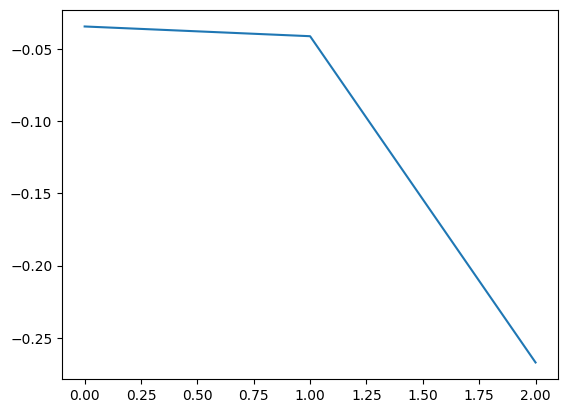

In [23]:
all_average_rewards.plot()

As we can see, after only 3 epochs, so significant improvement can be yet seen except that the initial RL Agent setup starts at being weaker than the benchmark. However, at 3 epochs we're still pretty early into the training regime, and a higher max Epoch may still lead to the network learning. Furthermore, there are a lot of hyperparameters we haven't explored, and RL setups usually require some amount of iteration. For now, we'll demonstrate how we can extract new inferred training schedules from the RL Agent.

To get the RLAgents schedule, we'll first retrieve the original TWAP schedule we want to compare against. We then run this benchmark schedule_twap throught the trained RLAgent using env.multistep() and a given set of data (provided in the env.restart() call). Within this function, the trained Agent will mutate this schedule, resulting in a new set of actions. We use these actions to reconstruct the mutated schedule_rl. We'll then run both the original and the mutated schedule through the backtester on the same data again, using run_schedule from RLAnalytics.py.

In [28]:
# Initialize environment with given agent and schedule, run and generate the RL agent schedule
data_feed = DataFeed(data, levels=10)
time_start = 1710498273005237 #random.choice(data.index)
#print(time_start)
env.reset(schedule_twap, data_feed, side, start_time_at=time_start)
all_values_per_step, all_states_per_step, all_action_per_step, all_log_prob_per_step, all_rewards_per_step, cumulative_reward, done = env.multistep_infer()
schedule_rl = {}
for i in range(len(all_action_per_step)):
    schedule_rl.update({i: ScheduleExecutor.LimitEvent(side, max_time, max_volume * all_action_per_step[i])})
schedule_rl.update({len(schedule_rl): ScheduleExecutor.MarketEvent(side, max_time)})

Here the order execution backtest for the benchmark TWAP schedule:

<Axes: ylabel='Price'>

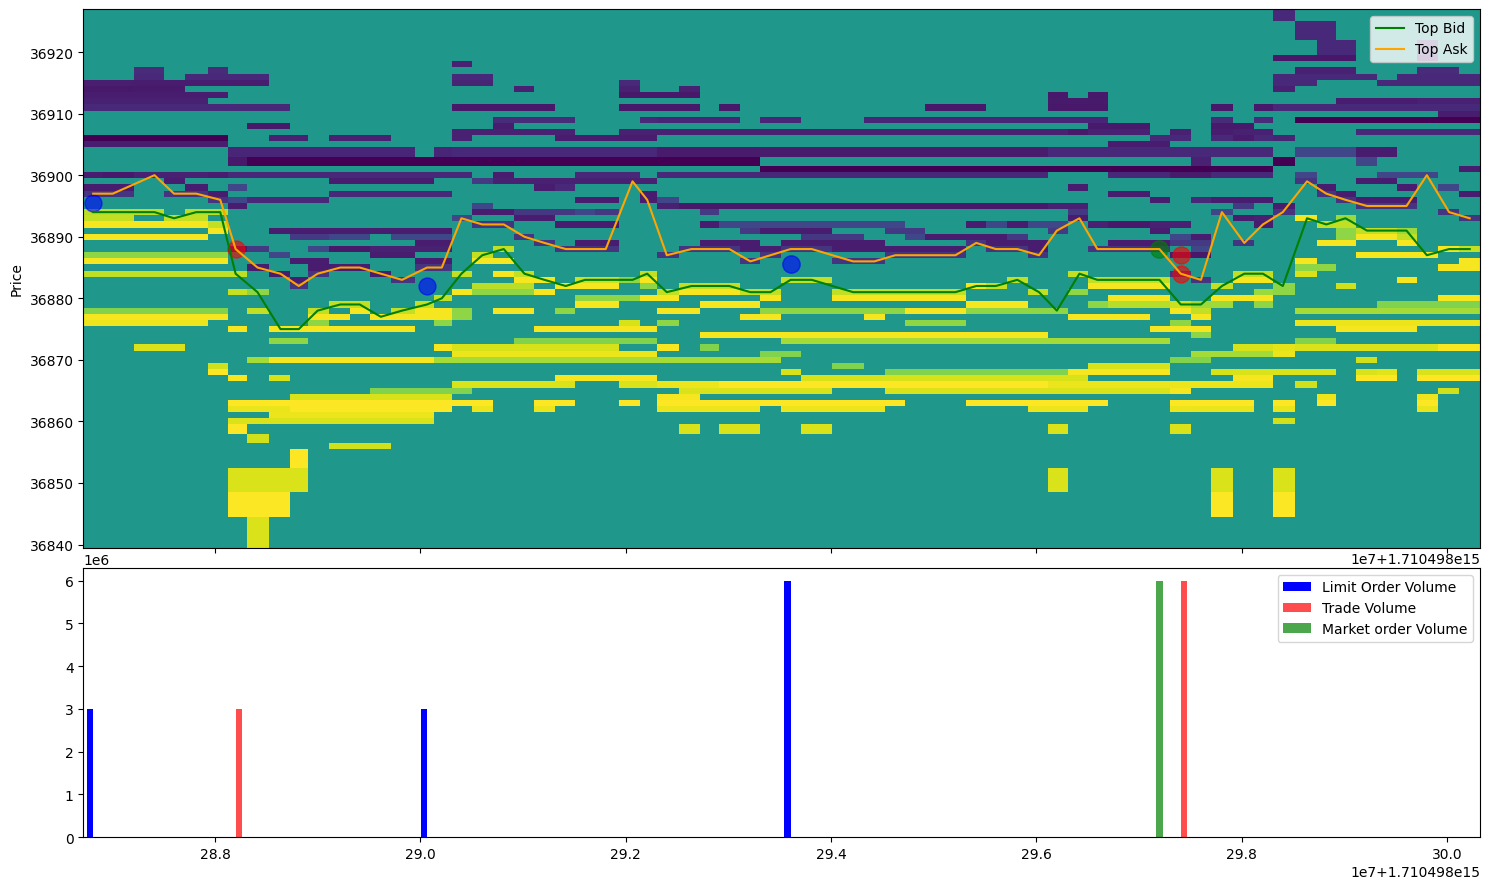

In [29]:
# plot the benchmark twap schedule
data_gen_twap = data_feed.raw_data_yield_fun(time_start)
trades_collect_all_twap, tick_data_bids_all_twap, tick_data_asks_all_twap, carryover_vol_twap, all_filled_twap, placed_limit_orders_collect_all_twap, placed_market_orders_collect_all_twap = RLAnalytics.run_schedule(schedule=schedule_twap, data_gen=data_gen_twap, levels=10, resubmit_each_tick=resubmit_each_tick, price_level_offset=price_level_offset)
RLAnalytics.plot_lob_data_with_volume(schedule_twap, data_gen_twap, resubmit_each_tick=resubmit_each_tick, price_level_offset=price_level_offset)

And here the RL Agents schedule for the same time period:

<Axes: ylabel='Price'>

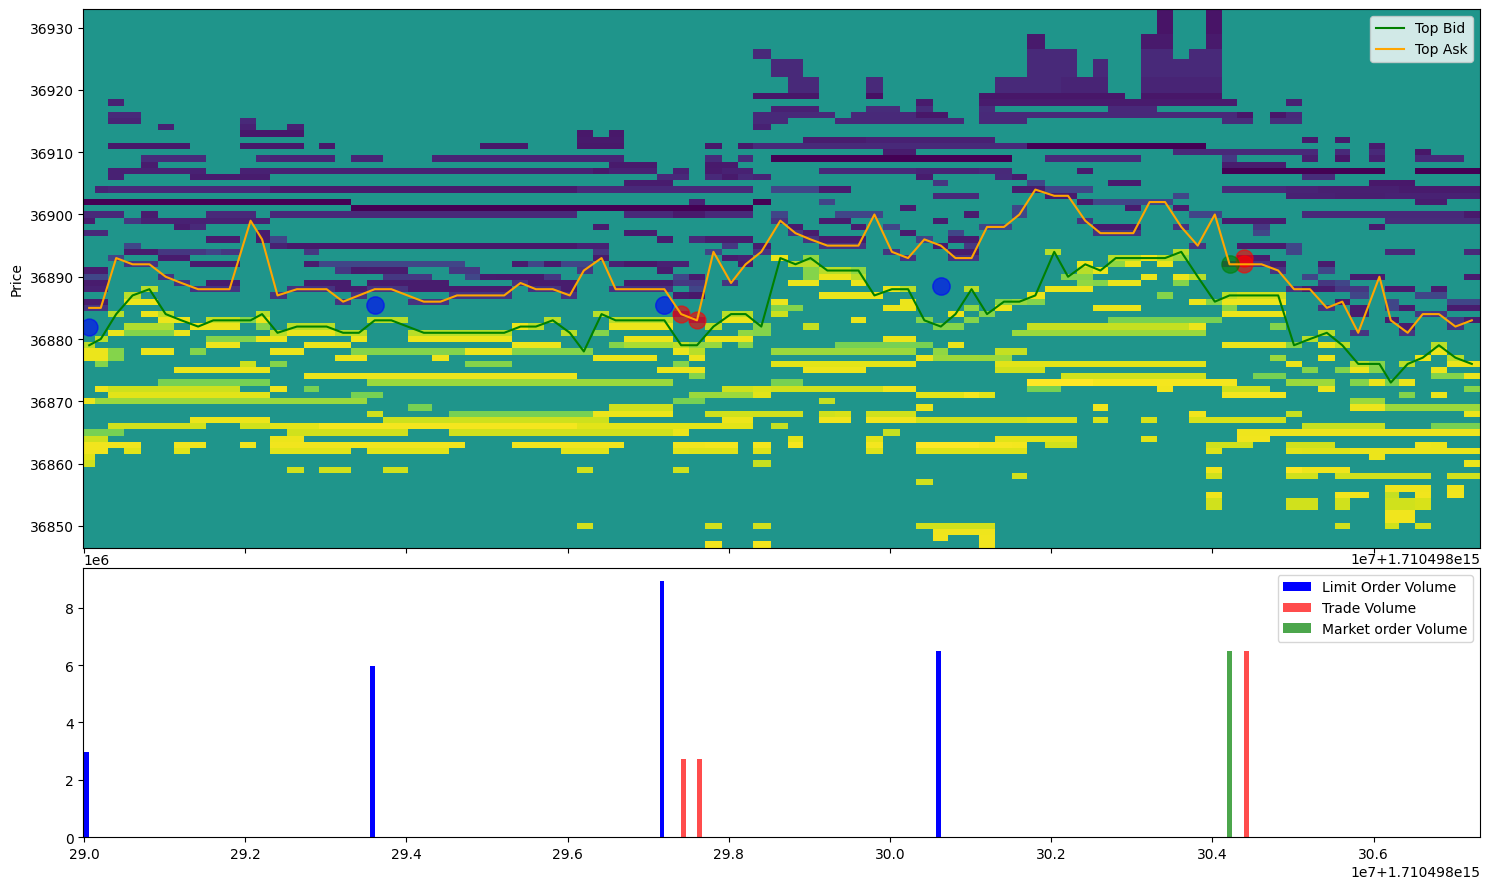

In [30]:

# plot the RL agents schedule
data_gen_rl = data_feed.raw_data_yield_fun(time_start)
trades_collect_all_rl, tick_data_bids_all_rl, tick_data_asks_all_rl, carryover_vol_rl, all_filled_rl, placed_limit_orders_collect_all_rl, placed_market_orders_collect_all_rl = RLAnalytics.run_schedule(schedule=schedule_rl, data_gen=data_gen_rl, levels=10, resubmit_each_tick=resubmit_each_tick, price_level_offset=price_level_offset)
RLAnalytics.plot_lob_data_with_volume(schedule_rl, data_gen_rl, resubmit_each_tick=resubmit_each_tick, price_level_offset=price_level_offset)

Its clear that the RLAgent is choosing a different schedule. Lets look at the reward structure of the modiefied RL schedule.

<Axes: >

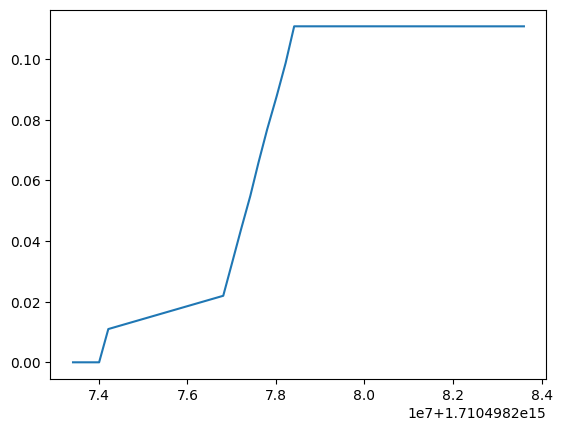

In [31]:
cumulative_reward = 0
exec_price_rl_cumulative = 0
exec_volume_rl_cumulative = 0
exec_price_twap_cumulative = 0
exec_volume_twap_cumulative = 0
cumulative_rewards = {}
keys_rl = set(trades_collect_all_rl.keys())
keys_twap = set(trades_collect_all_twap.keys())
# Find the intersection of both sets to get common keys
common_keys = keys_rl.intersection(keys_twap)
common_keys = sorted(common_keys)
for timestep in common_keys:
    trades_rl = trades_collect_all_rl[timestep]
    trades_twap = trades_collect_all_twap[timestep]

    # Update RL execution price and volume for this timestep
    for trade in trades_rl:
        for p, v in trade.price_levels.items():
            exec_price_rl_cumulative += p * v
            exec_volume_rl_cumulative += v

    # Update TWAP execution price and volume for this timestep
    for trade in trades_twap:
        for p, v in trade.price_levels.items():
            exec_price_twap_cumulative += p * v
            exec_volume_twap_cumulative += v

    # Calculate VWAPs for RL and TWAP up to current timestep
    rl_vwap = (exec_price_rl_cumulative / exec_volume_rl_cumulative) if exec_volume_rl_cumulative > 0 else 0
    twap_vwap = (exec_price_twap_cumulative / exec_volume_twap_cumulative) if exec_volume_twap_cumulative > 0 else 0

    # Update the cumulative reward
    cumulative_reward += twap_vwap - rl_vwap

    # Optionally store the cumulative reward at each timestep if needed for analysis
    cumulative_rewards[timestep] = cumulative_reward
cumulative_rewards_df = pd.Series(cumulative_rewards).sort_index()
cumulative_rewards_df.plot()

Note that we can choose a different time_start to see how the agent operates on other data slices. Also, during inference, we do not sample from the beta distribution but rather choose its mean, which is $\mu = \frac{\alpha}{\alpha + \beta}$ for the action value.

### 11. Beyond toy RL examples

As already mentioned, this implementation is really basic. The assumptions that had to be made to build a tractable environment are very restrictive given the data granularity. Here's the other extreme - an advanced setup that is realistically achieveable:

- Fully modeled exchange + interacting reactive agents with some given strategy pool. All agents as well as exchange have inventory models.
- Messaging / Server Exchange layer for full message granularity (order + acknowledgements etc.), this allows for latency modeling
- RL system in this setup is just another agent interacting with the simulated exchange. Same rules for all agents.
- Run Market Simulation in separate process to RL agent. Messaging-based info flow (like real life). Step() methods become message event-driven. RL setup becomes cycle-based instead of tick based. This guarantees a RL agent that acts close to real-life situations, also in terms of computational complexity / latency
- Train on various market types (different agent setups, zero intelligence, liquidity takers, market makers etc.)

This kind of setup essentially allows training of many kind of RL models - does not need to be order execution optimization, could also be testing RL on the algo itself, on inventory risk management, forcasting of signals etc. No need to re-build a new environment every time, just the reward layer on the learning layer should be modular.